<a href="https://colab.research.google.com/github/solarslurpi/GrowBuddies/blob/main/growbuddiesproject/growbuddies/drgrowbuddy/data_preprocessing_learnings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Preprocessing Learnings
I am working on the Dr. GrowBuddy project.  The goal of Dr. GrowBuddy is to take in images (and eventually text?) and from that, determine what is wrong with the (Cannabis) plant.

To do this, I'll be using Deep Learning.  I decided to use the PyTorch library.  I had been evaluating TensorFlow.  However, I found PyTorch far more intuitive and it seems like most data scientists feel the same way since PyTorch has grown in popularity whereas TensorFlow has not.

The notebook is about getting images that will be used during Deep Learning into a PyTorch Dataset.



## Learn By Doing - Small Project
I've identified a small first project to get Dr. GrowBuddy going.  I will use an existing plant dataset and create two features/labels: healthy and unhealthy leaves.  These will be used to train and test a model.  I'll feed it images of healthy Cannabis leaves with the hopes that the model will choose the healthy label for it.

# Dataset 


## The Plant Village Dataset
After bumbling around the Internet, I found [the PlantVillage Dataset in Papers With Code](https://paperswithcode.com/dataset/plantvillage). 


# Explore Images

## Get Images into Colab

In [2]:
# Get the images into Colab
from pathlib import Path
import zipfile

from google.colab import drive
drive.mount('/gdrive')

path = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'

if Path(path).exists():
    print(f"The path {path} exists.")
else:
    print(f"The path {path} does not exist.")
with zipfile.ZipFile(path, "r") as zip_ref:
    num_files = len(zip_ref.namelist())
    print(f"Number of files in the zip file: {num_files}")

Mounted at /gdrive
The path /gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip exists.
Number of files in the zip file: 55488


## Plot Distribution 
1. Create a dictionary in which the keys are the subdirectory names and the value is the number of files (in this case images) within the directory.

In [3]:
# Build a directory_name: number of images
from pathlib import Path
import zipfile

path = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'

dir_count = {}
with zipfile.ZipFile(path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        p = Path(file)
        parent_dir = p.parent
        subdir_name = parent_dir.name
        # Check if the current subdir_name already exists as a key in the dir_count dictionary. 
        # If it does, increment the value associated with that key by 1. 
        # If it doesn't, it creates a new key-value pair in the dictionary
        if subdir_name in dir_count:
            dir_count[subdir_name] += 1
        else:
            dir_count[subdir_name] = 1

print(dir_count)



{'': 1, 'Plant_leave_diseases_dataset_without_augmentation': 39, 'Apple___Apple_scab': 630, 'Apple___Black_rot': 621, 'Apple___Cedar_apple_rust': 275, 'Apple___healthy': 1645, 'Background_without_leaves': 1143, 'Blueberry___healthy': 1502, 'Cherry___healthy': 854, 'Cherry___Powdery_mildew': 1052, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Corn___Common_rust': 1192, 'Corn___healthy': 1162, 'Corn___Northern_Leaf_Blight': 985, 'Grape___Black_rot': 1180, 'Grape___Esca_(Black_Measles)': 1383, 'Grape___healthy': 423, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Peach___Bacterial_spot': 2297, 'Peach___healthy': 360, 'Pepper,_bell___Bacterial_spot': 997, 'Pepper,_bell___healthy': 1478, 'Potato___Early_blight': 1000, 'Potato___healthy': 152, 'Potato___Late_blight': 1000, 'Raspberry___healthy': 371, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Strawberry___healthy': 456, 'Strawberry___Leaf_scorch': 1109, 'Tomato__

2. use Matplotlib to plot.

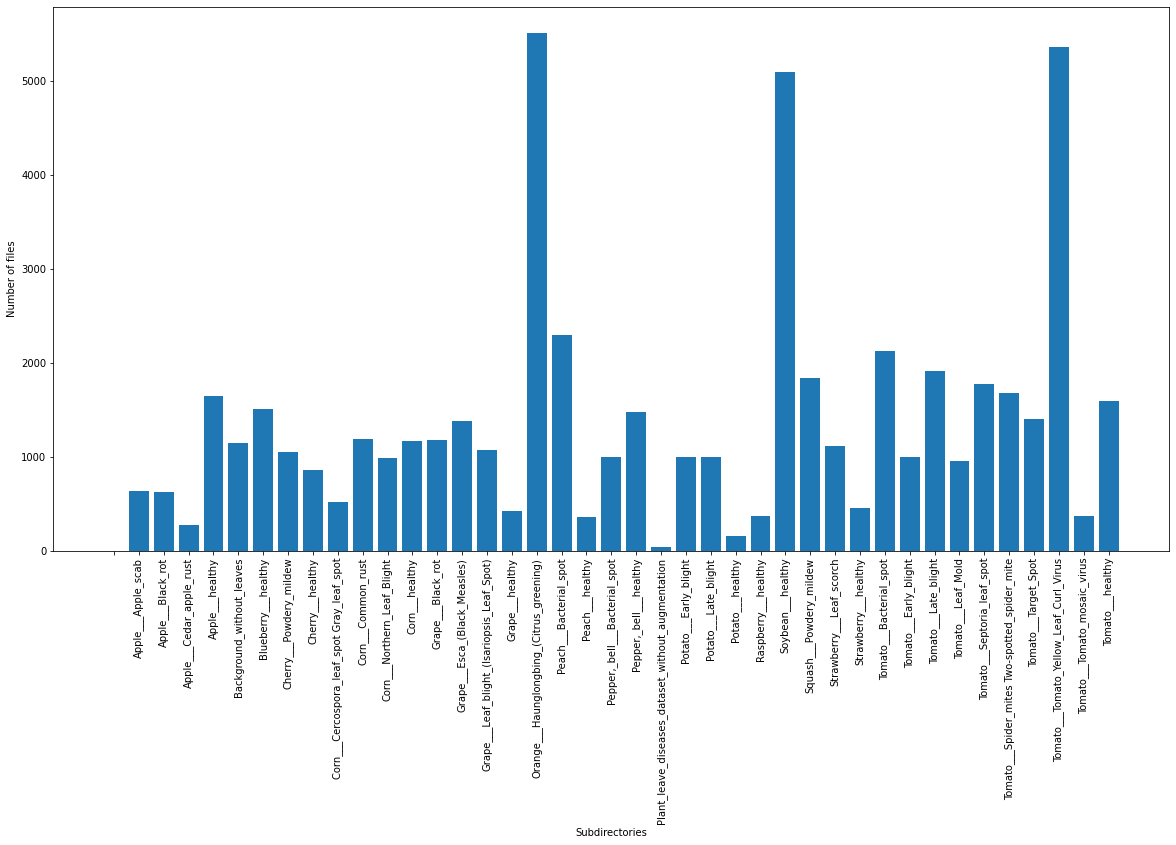

In [4]:
import matplotlib.pyplot as plt
sorted_keys = sorted(dir_count.keys())
plt.figure(figsize=(20, 10))
plt.bar(sorted_keys, [dir_count[key] for key in sorted_keys])
plt.xticks(rotation=90)
plt.xlabel('Subdirectories')
plt.ylabel('Number of files')
#
plt.show()

## Pull out Images for Deep Learning
The function "pull_out_images(nImages_per_directory)" scans a zip file and extracts a random selection of nImages_per_directory images.



In [5]:
from pathlib import Path
from zipfile import ZipFile
import random
"""
The script uses the ZipFile module to open the zip file specified by the zip_filepath and iterates through the directories.
For each directory name, it checks if the name contains a string from the dir_names list. 
If the directory includes one of the strings in dir_names, the script 
takes a random sample of 10 files from the directory and extracts them to the specified target directory.  The target directory will be identified as either 
healthy_target_dir or unhealthy_target_dir. The extracted files are also renamed to include the name of the plant species in the file name.

The zip file should be specified at zip_filepath, and the target directories for the healthy and unhealthy images should 
be specified at healthy_target_dir and unhealthy_target_dir respectively. The dir_names variable contains a list of names 
of the plant species to be considered.
"""


# specify the zip file and the target directory
def pull_out_images(nImages_per_directory):
    zip_filepath = '/gdrive/MyDrive/Colab_datasets/Plant_leaf_diseases_dataset_without_augmentation.zip'
    healthy_target_dir = '/content/drgrowbuddy/healthy/'
    unhealthy_target_dir = '/content/drgrowbuddy/unhealthy/'
    # Path.mkdir('/content/healthy')
    dir_names = ["Apple","Grape","Pepper,_bell","Potato","Raspberry","Soybean","Strawberry"]
    # open the zip file
    with ZipFile(zip_filepath, 'r') as zip_ref:
        # iterate through the directories within the zip file
        for directory in (f for f in zip_ref.namelist() if f.endswith('/')):
          # Check if the directory name contains both an entry from the dir_names list as well as the word "healthy"
          if any(name in directory for name in dir_names):
            files = zip_ref.namelist()
            files = [file for file in files if directory in file]
            # take a random sample of files from the directory.
            files = random.sample(files,nImages_per_directory)
            dir_path = Path(directory)
            subdir_name = dir_path.parts[-1]
            for name in dir_names:
              if name in subdir_name:
                  short_dir_name = name
                  break

            for file in files:
                zip_info = zip_ref.getinfo(file)
                zip_info.filename = zip_info.filename.replace("image",short_dir_name)
                zip_info.filename = Path(zip_info.filename).name
                if "healthy" in directory:
                  target_dir = healthy_target_dir
                else:
                  target_dir = unhealthy_target_dir
                zip_ref.extract(zip_info, target_dir)


pull_out_images(10)


## Randomly Show an Image
PyTorch uses PIL image format. So let's use the PIL() class to randomly show one of the images we grabbed from calling "pull_out_images(10)".


There are a total of 170 images.
-------------------------
Image path:  /content/drgrowbuddy/unhealthy/Grape (39).JPG
Fruit name:  Grape
Class:       unhealthy
Image size:  (256, 256)
Image mode:  RGB


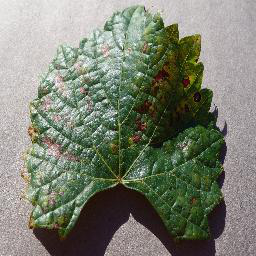

In [6]:
from pathlib import Path
import random
from PIL import Image

# setup
healthy_dir = Path('/content/drgrowbuddy/healthy')
unhealthy_dir = Path('/content/drgrowbuddy/unhealthy')
# Get the list of filepaths
images_list = list(healthy_dir.glob('*.JPG')) + list(unhealthy_dir.glob('*.JPG'))
print(f"There are a total of {len(images_list)} images.")
chosen_image_path = random.choice(images_list)
file_name = chosen_image_path.parts[-1]
dir_names = ["Apple","Grape","Pepper,_bell","Potato","Raspberry","Soybean","Strawberry"]
fruit_name = [name for name in dir_names if name in file_name][0]
image = Image.open(chosen_image_path)
class_name = chosen_image_path.parent.stem
print("-------------------------")
# dir_names = ["Apple","Grape","Pepper,_bell","Potato","Raspberry","Soybean","Strawberry"]
#  # Can use matplotlib to show or just show by typing image on a line, e.g.: plt.imshow(image)
print("Image path: ", chosen_image_path)
print("Fruit name: ", fruit_name)
print("Class:      ", class_name)
print("Image size: ", image.size)
print("Image mode: ", image.mode)
image

# Build a DataSet and DataLoader
A dataset in PyTorch is a collection of data to be analyzed.  In our case, we have a "big box" (or perhaps better stated a "bunch of bits") of pictures. A dataloader takes out small batches of pictures from that big box. So, the dataset is where you store all your data and the dataloader is what you use to access it during training or testing of your model.

`torch.utils.data.Dataset` - indexable/subscriptable (image_dataset[5] works fine for example). It is a simple object which defines how to get a single (usually single) sample of data.

`torch.utils.data.DataLoader` - non-indexable, only iterable (can loop over), usually returns batches of data from a Dataset.  

## The Dataset


PyTorch's `torchvision` library provides the [`ImageFolder()` class](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) to swiftly get our images into a PyTorch Dataset.  


When creating an instance of the `ImageFolder()` class in PyTorch, one important parameter to consider is the `transform` property. This property allows you to pass in a function that can be used to transform an image in various ways. For example, you might use it to resize an image to a smaller size, or to augment the image by applying different types of transformations, such as rotating or flipping the image. These transformations can help to increase the number of images available for training or testing your model, and can also help to reduce overfitting by providing a more diverse set of data. Additionally, the `toTensor()` transform will transform the contents of the image file into a tensor, which is the data format that PyTorch uses for training and evaluating models.    
  

### A Transform Function
__More info__: [PyTorch doc, _Transforming and Augmenting images_](https://pytorch.org/vision/stable/transforms.html#transforming-and-augmenting-images)

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# Write the transform for an image.
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224,224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])


### Show Original and Transform of Random Image

In [8]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


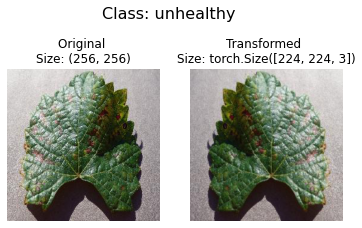

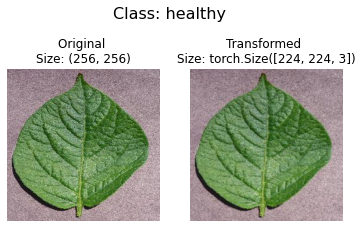

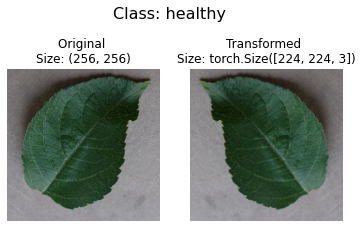

In [9]:
# setup
healthy_dir = Path('/content/drgrowbuddy/healthy')
unhealthy_dir = Path('/content/drgrowbuddy/unhealthy')
# Get the list of filepaths
image_paths = list(healthy_dir.glob('*.JPG')) + list(unhealthy_dir.glob('*.JPG'))
plot_transformed_images(image_paths, data_transform, n=3, seed=42)

In [10]:
# Use imagefolder to create the PyTorch dataset (TorchVision)
from torchvision import datasets

dataset = datasets.ImageFolder(root='/content/drgrowbuddy', transform = data_transform, target_transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 170
    Root location: /content/drgrowbuddy
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [11]:
classnames = dataset.classes
classdict = dataset.class_to_idx
print(f"Classnames: {classnames} index: {classdict}")
dataset.samples[0]

Classnames: ['healthy', 'unhealthy'] index: {'healthy': 0, 'unhealthy': 1}


('/content/drgrowbuddy/healthy/Apple (1088).JPG', 0)

In [12]:
dataset[1][1]

0

In [13]:
# Index on the dataset to get a single image and label.
# dataset[0] contains both the data for the first image as well as the label.
# dataset[0][0] is the data (image) and dataset[0][1] is the label of the first image.
img, label = dataset[0][0], dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
print(f"Label name: {classnames[label]}")

Image tensor:
tensor([[[0.6667, 0.6784, 0.6863,  ..., 0.7059, 0.7020, 0.7137],
         [0.6471, 0.6549, 0.6627,  ..., 0.7098, 0.6941, 0.6588],
         [0.6510, 0.6471, 0.6471,  ..., 0.6941, 0.7765, 0.7333],
         ...,
         [0.4588, 0.4627, 0.4627,  ..., 0.4902, 0.4824, 0.4941],
         [0.4627, 0.4667, 0.4745,  ..., 0.4824, 0.4863, 0.5020],
         [0.4627, 0.4588, 0.4706,  ..., 0.5098, 0.5137, 0.5216]],

        [[0.6078, 0.6196, 0.6275,  ..., 0.6588, 0.6549, 0.6667],
         [0.5882, 0.5961, 0.6039,  ..., 0.6627, 0.6471, 0.6118],
         [0.5922, 0.5882, 0.5882,  ..., 0.6471, 0.7294, 0.6863],
         ...,
         [0.3804, 0.3843, 0.3843,  ..., 0.4196, 0.4118, 0.4235],
         [0.3843, 0.3882, 0.3961,  ..., 0.4118, 0.4157, 0.4314],
         [0.3843, 0.3804, 0.3922,  ..., 0.4392, 0.4431, 0.4510]],

        [[0.5961, 0.6078, 0.6157,  ..., 0.6588, 0.6549, 0.6667],
         [0.5765, 0.5843, 0.5922,  ..., 0.6627, 0.6471, 0.6118],
         [0.5804, 0.5765, 0.5765,  ..., 0.64

Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


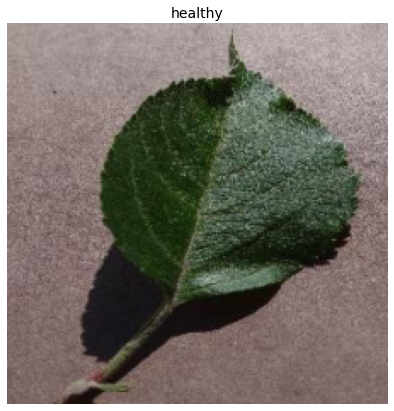

In [14]:

# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(classnames[label], fontsize=14);

### Instantiate the Dataset
As noted previously, PyTorch's `torchvision` library provides the [`ImageFolder()` class](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) to swiftly get our images into a PyTorch Dataset.  

In [15]:
from torchvision import datasets
dir_path = '/content/drgrowbuddy'

image_dataset = datasets.ImageFolder(root=dir_path,transform=data_transform)
image_dataset

Dataset ImageFolder
    Number of datapoints: 170
    Root location: /content/drgrowbuddy
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

### Explore ImageFolder()



Image tensor:
tensor([[[0.6667, 0.6784, 0.6863,  ..., 0.7059, 0.7020, 0.7137],
         [0.6471, 0.6549, 0.6627,  ..., 0.7098, 0.6941, 0.6588],
         [0.6510, 0.6471, 0.6471,  ..., 0.6941, 0.7765, 0.7333],
         ...,
         [0.4588, 0.4627, 0.4627,  ..., 0.4902, 0.4824, 0.4941],
         [0.4627, 0.4667, 0.4745,  ..., 0.4824, 0.4863, 0.5020],
         [0.4627, 0.4588, 0.4706,  ..., 0.5098, 0.5137, 0.5216]],

        [[0.6078, 0.6196, 0.6275,  ..., 0.6588, 0.6549, 0.6667],
         [0.5882, 0.5961, 0.6039,  ..., 0.6627, 0.6471, 0.6118],
         [0.5922, 0.5882, 0.5882,  ..., 0.6471, 0.7294, 0.6863],
         ...,
         [0.3804, 0.3843, 0.3843,  ..., 0.4196, 0.4118, 0.4235],
         [0.3843, 0.3882, 0.3961,  ..., 0.4118, 0.4157, 0.4314],
         [0.3843, 0.3804, 0.3922,  ..., 0.4392, 0.4431, 0.4510]],

        [[0.5961, 0.6078, 0.6157,  ..., 0.6588, 0.6549, 0.6667],
         [0.5765, 0.5843, 0.5922,  ..., 0.6627, 0.6471, 0.6118],
         [0.5804, 0.5765, 0.5765,  ..., 0.64

(-0.5, 223.5, 223.5, -0.5)

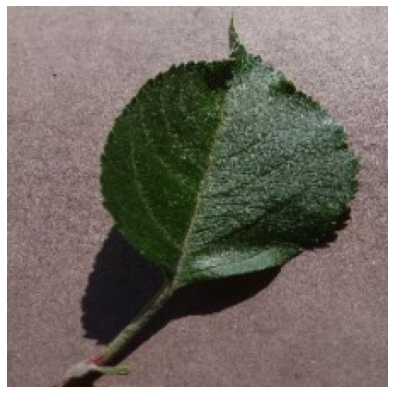

In [16]:
img, label = image_dataset[0][0], image_dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Image class:    {image_dataset.classes[label]}")
print(f"Label datatype: {type(label)}")
# To look at an image, we have to put the color channel in the right place.
# torchvision uses CHW As seen below (3, 224, 224)
# matplotlib uses HWC
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")


### Train/Test Split
We need to have a training dataset and a test dataset.

In [17]:
from torch.utils.data import random_split

# Assume your dataset is called "my_dataset"
train_ratio = 0.8
train_size = int(train_ratio * len(image_dataset))
test_size = len(image_dataset) - train_size
train_dataset, test_dataset = random_split(image_dataset, [train_size, test_size])
train_dataset, test_dataset


(<torch.utils.data.dataset.Subset at 0x7ffa0eaeedc0>,
 <torch.utils.data.dataset.Subset at 0x7ffa0eaeecd0>)

## The DataLoader
The `DataLoader` utility class takes a dataset as input and provides an iterable over the dataset.  This way it can provide batches of images. It also provides useful features such as shuffling the data, and loading the data in parallel using multiple workers.

In [18]:
# Turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader
def make_dataloaders(batch_size=1):
    print(f"--> in make_dataloaders.  Batch size is {batch_size}")
    train_dataloader = DataLoader(dataset=train_dataset, 
                                  batch_size=batch_size,
                                  shuffle=True)

    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False)
    return(train_dataloader, test_dataloader)

### The Batch Size
The batch size refers to the number of images included in a single batch during training or evaluation. It is determined by dividing the total number of images in the dataset by the number of batches that need to be created. This allows the model to process multiple images at once, rather than processing them one at a time.

The example below shows the differences in number of training batches based on the batch_size.  It points out in the ideal case, the batch size divides evenly into the total number of images in a dataset.

In [19]:
batch_size = 1
train_dataloader, test_dataloader = make_dataloaders(batch_size)
print(f"Batch size = {batch_size}.  The number of training batches is {len(train_dataloader)}.  The number of test batches is {len(test_dataloader)}")
batch_size = 32
train_dataloader, test_dataloader = make_dataloaders(batch_size)
print(f"Batch size = {batch_size}.  The number of training batches is  {len(train_dataloader)}.  The number of test batches is {len(test_dataloader)}")

--> in make_dataloaders.  Batch size is 1
Batch size = 1.  The number of training batches is 136.  The number of test batches is 34
--> in make_dataloaders.  Batch size is 32
Batch size = 32.  The number of training batches is  5.  The number of test batches is 2


Notice how the batch size was added to the shape.

In [20]:
img, label = next(iter(train_dataloader))


# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image datatype: {type(img)}")
print(f"Image shape:    {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape:    {label.shape}")


Image datatype: <class 'torch.Tensor'>
Image shape:    torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape:    torch.Size([32])


# Build A CNN Model
CNN's are known for their ability to find patterns in images.
- see [CNN Explainer website](https://poloclub.github.io/cnn-explainer/) and [the YouTube video](https://www.youtube.com/watch?v=HnWIHWFbuUQ) that explains it.  



In [21]:
from torch import nn
class GrowBuddiesModel(nn.Module):
  def __init__(self):
    super().__init()


# Data Augmentation
The image below - from the Medium article titled ["Data Augmentation - Is it really necessary?"](https://medium.com/analytics-vidhya/data-augmentation-is-it-really-necessary-b3cb12ab3c3f) provides a great visual on how a few of the available transformations that can be used to add (augment) images to a dataset.

In [22]:
%%html
<img src='https://miro.medium.com/max/1400/1*KL_HqR2bU9yvMLce9ilPxg.webp' width=700/>